# Capstone Project - The Battle of Neighborhoods

Find the best sushi restaurant in New York City
New York City is the is the largest city in the United States, and is a large and ethnically diverse metropolis. In 2017, New York City had a population of 8,622,698 people. The diverse culture of NYC makes it a great place for different and high quality restaurants.

My wife and I are big fans of Japanese cuisine, especially sushi. In every city we go, we have to try at least one sushi restaurant. Sadley, my favorite sushi restaurant in NYC has been closed. In this project, I want to find the best sushi restaurant for us to visit on our next trip to NYC.

Data
The following data is used in the project:
1 - Boroughs and Neighborhoods in NYC: https://cocl.us/new_york_dataset
2 - Sushi resturants from Foursquare API

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [3]:
!pip install folium

     |████████████████████████████████| 92kB 6.7MB/s eta 0:00:011


In [4]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
from os import path
from PIL import Image

# import k-means from clustering stage
from sklearn.cluster import KMeans
import folium # map rendering library

In [5]:
import urllib.request
urllib.request.urlretrieve("https://cocl.us/new_york_dataset", 'newyork_data.json')
print('Data downloaded!')

Data downloaded!


In [6]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)
    

In [7]:
neighborhoods_data = newyork_data['features']
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

# Methodology¶

I will analyze and visulaize the data to find the best restaurant. 

I will collect data from foursquare that include ratings for the restaurnts to help me in the selection process

In [8]:
neighborhoods.head()


,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [9]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


In [10]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_newyork)  
    
map_newyork

In [11]:
# @hidden_cell
CLIENT_ID = '***********************************************' # your Foursquare ID
CLIENT_SECRET = '***********************************************' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
CLIENT_ID = '***********************************************' # your Foursquare ID
CLIENT_SECRET = '***********************************************' # your Foursquare Secret
CLIENT_ID = '***********************************************'
CLIENT_SECRET = '***********************************************'
CLIENT_ID = "***********************************************"
CLIENT_SECRET = "***********************************************"

In [15]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            v['venue']['id'],
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                             'id',
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [16]:

LIMIT = 100
ny_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

In [17]:
ny_venues.head()

,Neighborhood,id,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Wakefield,4c537892fd2ea593cb077a28,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Wakefield,4d375ce799fe8eec99fd2355,40.894705,-73.847201,Ripe Kitchen & Bar,40.898152,-73.838875,Caribbean Restaurant
2,Wakefield,4c9e50e38afca09379b2ff15,40.894705,-73.847201,Ali's Roti Shop,40.894036,-73.856935,Caribbean Restaurant
3,Wakefield,4c783cef3badb1f7e4244b54,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
4,Wakefield,4c1bed4eb306c928140763b7,40.894705,-73.847201,Jimbo's,40.891740,-73.858226,Burger Joint


In [19]:
# get the Suchi restaurants
sushi_rest = ny_venues[ny_venues['Venue Category']=="Sushi Restaurant"].reset_index(drop=True).drop_duplicates(subset=['id'], keep='first')
sushi_rest.head()
sushi_rest.shape

(151, 8)

In [20]:

map_newyork_sushi = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, ven in zip(sushi_rest['Venue Latitude'], sushi_rest['Venue Longitude'], sushi_rest['Venue']):
    label = folium.Popup(str(ven), parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_newyork_sushi)  
    
map_newyork_sushi

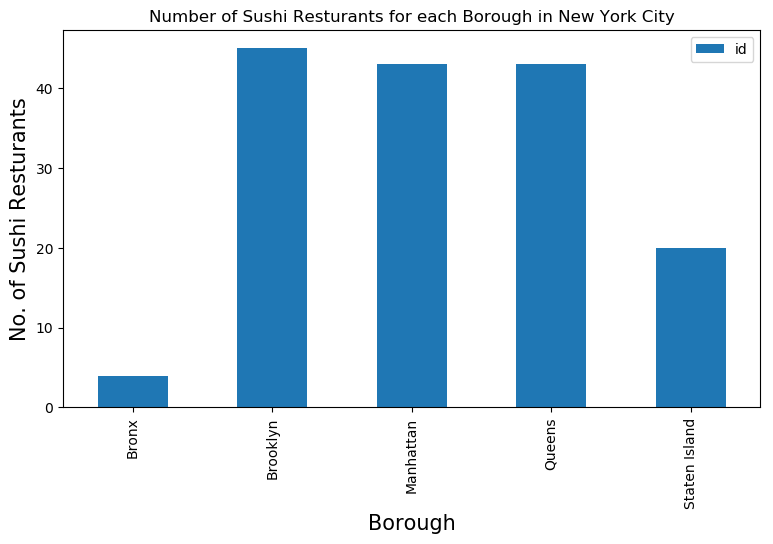

In [21]:
#how many restaurants are there by Borough

sushi_rest_b = pd.merge(sushi_rest, neighborhoods[["Neighborhood","Borough"]]  , on='Neighborhood')
# Then we plot
plt.figure(figsize=(9,5), dpi = 100)
# title
plt.title('Number of Sushi Resturants for each Borough in New York City')
#On x-axis
plt.xlabel('Borough', fontsize = 15)
#On y-axis
plt.ylabel('No. of Sushi Resturants', fontsize=15)
#giving a bar plot
sushi_rest_b.groupby('Borough')['id'].count().plot(kind='bar')
#legend
plt.legend()
#displays the plot
plt.show()


Now let's see how many restaurants per neighborhood (I will only take neighborhoods with more than 2 sushi restaurants)

In [23]:

per_N = sushi_rest_b.groupby('Neighborhood')['Venue'].count().reset_index(name="count")
per_N.sort_values('count', ascending=False ).head(10)

,Neighborhood,count
73,Sheepshead Bay,5
45,Manhattan Terrace,4
26,Eltingville,4
6,Bayside,4
54,Murray Hill,4
41,Kew Gardens Hills,3
42,Lenox Hill,3
43,Lincoln Square,3
32,Greenwich Village,3
12,Brighton Beach,3


In [24]:
#  collect the ratings, number of reviewers, and number of likes

sushi_rest_b["Rating"] = np.nan
sushi_rest_b["Likes"] = np.nan
sushi_rest_b["No. of Ratings"] = np.nan
venue_data = []

In [25]:
for i in range(0,len(sushi_rest_b)):
    ID = sushi_rest_b['id'][i]
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
        ID,
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION)
    results = requests.get(url).json()
    venue_data=results['response']['venue']
    # continue in case any information is not available
    try:
        sushi_rest_b["Likes"][i] =venue_data['likes']['count']
    except KeyError:
        pass
    try:
        sushi_rest_b["Rating"][i] = venue_data['rating']
        sushi_rest_b["No. of Ratings"][i] = venue_data['ratingSignals']
    except KeyError:
        pass

/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/envs/Python36/lib/python3.6/site-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


# Results and Discussions

I will examine the highest rated restaurants in this section

In [26]:
sushi_rest_b.sort_values('Rating', ascending=False ).reset_index(drop=True)


,Neighborhood,id,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Borough,Rating,Likes,No. of Ratings
0,Flatiron,5a0e475b018cbb6a2196479e,40.739673,-73.990947,Sushi By Bou,40.740883,-73.993525,Sushi Restaurant,Manhattan,9.4,78.0,88.0
1,Greenwich Village,5c6c6715f709c1002cd49290,40.726933,-73.999914,SUGARFISH by sushi nozawa,40.725300,-74.003507,Sushi Restaurant,Manhattan,9.3,80.0,90.0
2,Lenox Hill,501adf11e4b0d225f8788a03,40.768113,-73.958860,Tanoshi Sushi,40.767747,-73.953203,Sushi Restaurant,Manhattan,9.2,320.0,438.0
3,Greenwich Village,45ac12d6f964a5205d411fe3,40.726933,-73.999914,Blue Ribbon Sushi,40.726167,-74.002607,Sushi Restaurant,Manhattan,9.2,816.0,1087.0
4,Greenwich Village,555e7399498eccd4b34fe416,40.726933,-73.999914,DomoDomo,40.728007,-74.001683,Sushi Restaurant,Manhattan,9.2,273.0,355.0
5,Chelsea,49d991d9f964a5204a5e1fe3,40.744035,-74.003116,Momoya,40.742687,-73.996617,Sushi Restaurant,Manhattan,9.2,771.0,1028.0
6,Midtown,595ebd0aee712007dc5ae215,40.754691,-73.981669,Sushi By Bou,40.758679,-73.983045,Sushi Restaurant,Manhattan,9.2,83.0,109.0
7,West Village,52155e9d11d2c369404df14e,40.734434,-74.006180,Sushi Nakazawa,40.731719,-74.004400,Sushi Restaurant,Manhattan,9.2,654.0,863.0
8,Chelsea,49d991d9f964a5204a5e1fe3,40.744035,-74.003116,Momoya,40.742687,-73.996617,Sushi Restaurant,Staten Island,9.2,771.0,1028.0
9,Williamsburg,423e0e80f964a52048201fe3,40.707144,-73.958115,Bozu,40.712976,-73.957478,Sushi Restaurant,Brooklyn,9.1,506.0,700.0


In [27]:
#removing the low rated resturants (rating < 8)


sushi_rest_hr = sushi_rest_b[sushi_rest_b['Rating'] >=8.0]

sushi_rest_hr.shape


(69, 12)

rating of the restaurants in each neighborhood, but with all data (not only the highest rated ones)

In [28]:
sushi_neighborhood=sushi_rest_b.groupby('Neighborhood',as_index=False).mean()[['Neighborhood','Rating','No. of Ratings','Likes']]

pd.merge(sushi_neighborhood, per_N, on='Neighborhood').sort_values(['Rating'],ascending=False).head(10)


,Neighborhood,Rating,No. of Ratings,Likes,count
27,Flatiron,9.400000,88.000000,78.000000,1
32,Greenwich Village,9.233333,510.666667,389.666667,3
18,Chelsea,9.200000,1028.000000,771.000000,2
84,West Village,9.200000,863.000000,654.000000,1
86,Williamsburg,9.100000,700.000000,506.000000,1
64,Prospect Heights,9.050000,312.500000,240.000000,2
54,Murray Hill,8.950000,439.000000,309.500000,4
51,Midtown,8.950000,308.500000,214.500000,2
43,Lincoln Square,8.933333,501.333333,362.000000,3
52,Midtown South,8.900000,95.000000,72.000000,1


In [29]:
# for Boroughs

sushi_Borough=sushi_rest_b.groupby('Borough',as_index=False).mean()[['Borough','Rating','No. of Ratings','Likes']]
sushi_Borough.sort_values(['Rating'],ascending=False).head(10)

,Borough,Rating,No. of Ratings,Likes
2,Manhattan,8.432558,250.581395,178.558140
3,Queens,7.675000,85.375000,51.232558
1,Brooklyn,7.646512,73.720930,47.888889
4,Staten Island,7.429412,85.823529,51.250000
0,Bronx,7.425000,20.250000,10.750000


# The data shows that Manhattan has the best sushi restaurants

Let's narrow down the search to high rated restaurants in Manhattan

In [32]:
# rating higher than 8.5 and No. of Ratings > 200 and Likes > 100 
sushi_manhattan = sushi_rest_b[sushi_rest_b["Borough"]=="Manhattan"]
sushi_manhattan = sushi_manhattan[(sushi_manhattan["Rating"]>=9) & 
                                  (sushi_manhattan["No. of Ratings"]>300) & 
                                  (sushi_manhattan["Likes"]>200)].reset_index(drop=True)
sushi_manhattan.shape



(7, 12)

In [33]:
sushi_manhattan.sort_values(['Rating','No. of Ratings','Likes'],ascending=False).head(10)


,Neighborhood,id,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category,Borough,Rating,Likes,No. of Ratings
4,Greenwich Village,45ac12d6f964a5205d411fe3,40.726933,-73.999914,Blue Ribbon Sushi,40.726167,-74.002607,Sushi Restaurant,Manhattan,9.2,816.0,1087.0
2,Chelsea,49d991d9f964a5204a5e1fe3,40.744035,-74.003116,Momoya,40.742687,-73.996617,Sushi Restaurant,Manhattan,9.2,771.0,1028.0
6,West Village,52155e9d11d2c369404df14e,40.734434,-74.006180,Sushi Nakazawa,40.731719,-74.004400,Sushi Restaurant,Manhattan,9.2,654.0,863.0
0,Lenox Hill,501adf11e4b0d225f8788a03,40.768113,-73.958860,Tanoshi Sushi,40.767747,-73.953203,Sushi Restaurant,Manhattan,9.2,320.0,438.0
3,Greenwich Village,555e7399498eccd4b34fe416,40.726933,-73.999914,DomoDomo,40.728007,-74.001683,Sushi Restaurant,Manhattan,9.2,273.0,355.0
1,Lincoln Square,4ea75442f7903beac0782454,40.773529,-73.985338,Sushi Yasaka,40.779425,-73.983531,Sushi Restaurant,Manhattan,9.0,652.0,894.0
5,Tribeca,4a8f2f39f964a520471420e3,40.721522,-74.010683,Takahachi,40.716526,-74.008101,Sushi Restaurant,Manhattan,9.0,311.0,423.0


In [34]:
map_newyork_sushi = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers to map
for lat, lng, ven,rating in zip(sushi_manhattan['Venue Latitude'], 
                                sushi_manhattan['Venue Longitude'], sushi_manhattan['Venue'],sushi_manhattan['Rating']):
    label = '{}, {}'.format(str(ven), rating)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(map_newyork_sushi)  
    
map_newyork_sushi

# Conclusion

Mahnattan has many high quality sushi restaurants. 

I chose Blue Ribbon Sushi based on the rating, number of users who rated the restaurant, and number of likes.